# Cass-Koopmans Model (Part II)


In [1]:
using Roots
using NLsolve
using DataFrames
using Parameters
using Printf
using Plots

We follow closely Chen et al (AER). The planner's problem is
$$
\begin{aligned}
& \max _{\left\{c_t, h_t, k_{t+1}\right\}} \sum_{t=0}^{\infty} \beta^t N_t \log c_t \\
& \text { subject to } \\
& K_{t+1}+C_t=\left(1-\tau_t\left(r_t-\delta\right)\right) K_t+A_t K_t^\alpha\left(\gamma^t L_t\right)^{1-\alpha}
\end{aligned}
$$
where $\tau_t$ are capital income taxes. Also, assume that the size of the household is fixed $N_t=N_0$, and $\gamma=\left(A_{t+1} / A_t\right)^{1 /(1-\alpha)}$.

$$
\begin{gathered}
\widetilde{k}_{t+1}=\frac{1}{\gamma_t}\left[A_t\widetilde{k}_t^\alpha +(1-\delta) \widetilde{k}_t-\widetilde{c}_t\right]
\\
\widetilde{c}_{t+1}=\beta \frac{\widetilde{c}_t}{\gamma_t}\left\{(1-\delta)+\alpha A(\widetilde{k}_{t+1})^{\alpha-1}\right\}
\end{gathered}
$$
with $k_0 = \bar{k}$

$$
\begin{gathered}
\widetilde{a}_{t+1}=\frac{1}{\gamma_t}\left[r \widetilde{a}_{t+1}+ y_t -\widetilde{c}_t\right]
\\
\widetilde{c}_{t+1}=\beta \frac{\widetilde{c}_t}{\gamma_t} r
\end{gathered}
$$
with $a_0 = \bar{a}$

In [2]:
# Initial guess
p_gen = @with_kw (δ=0.10,    # depreciation rate for capital at SS
β=0.96327,  # utility discount factor 
α=0.363,     # share of capital in production
τk=0.0,
ψ=1.45,   # parameter for disutility of labor
n=1.02,
γ_ss = 1.0, #1.0315,
γ_new = 1.0, # 1.01*γ_ss,
A=1.0,
Th=105, 
N=200,
ϵ=0.001,
transp =100,
ky_data=3.6,
γt = [γ_ss;γ_new*ones(N-1)]
);

## Solving the system (simulating)

$$
\begin{gathered}
\widetilde{k}_{t+1}=\frac{1}{\gamma_t}\left[A_t\widetilde{k}_t^\alpha +(1-\delta) \widetilde{k}_t-\widetilde{c}_t\right] (1)
\\
\widetilde{c}_{t+1}=\beta \frac{\widetilde{c}_t}{\gamma_t}\left\{(1-\delta)+\alpha A(\widetilde{k}_{t+1})^{\alpha-1}\right\} (2)
\end{gathered}
$$
with $k_0 = \bar{k}$

## 1. Shooting: 
1. Guess a value for $\widetilde{c}_t$
2. Use equation (1) to obtain $\widetilde{k}_{t+1}$
3. Use equation (2) to obtain $\widetilde{c}_{t+1}$
4. Use equation (1) to obtain $\widetilde{k}_{t+2}$
...
....

In [3]:
function shooting(ck, c0, k0)
    (;β,α,γt,δ,N,A) = ck

    kt   = NaN*ones(N+1)
    ct   = NaN*ones(N+1)
    #kt   = Vector{Union{Missing, Float64}}(missing, N+1)
    #ct   = Vector{Union{Missing, Float64}}(missing, N+1)
    kt[1] = k0
    ct[1] = c0

    for t = 1:N
        #println(t," ct : ",ct[t],"  kt : ",kt[t])
        y_deprec = A*kt[t]^α + (1-δ)*kt[t]
        if ct[t]>=y_deprec
            #println("initial consumption is not feasible")
            break
        end
        #println(t," ct : ",ct[t],"  yt_dep : ",y_deprec,"  kt : ",kt[t])
        kt[t+1] = (1/γt[t])*(y_deprec - ct[t]) #equation (1)
        ct[t+1] = (1/γt[t])*ct[t]*β*( 1-δ + α*A*(kt[t+1])^(α-1) )#equation (1)
    end
    ct,kt
end

shooting (generic function with 1 method)

## 2. Bisection:
1. Uses the shooting algorithm in a "clever" way
2. Given an initial value for $k_0 = \bar{k}$, tries different guess for $c_0$
3. It needs initial boundaries for $c_0$
4. And given an initial value for $k_0$, runs a shooting with an "initial guess" of $c_0$
\
4.1 If the final value of $k$,  $k_T$, is different from the pre-set terminal value of $k$,$k_{TERMINAL}$, find another $c_0$
4.2 Depending on the difference between $k_T$ and $k_{TERMINAL}$, redifine $c_0$
4.3 Iterate until convergence or maximum iterations


In [4]:
function bisection(ck, c0, k0; tol=1e-4, max_iter=500, k_ter=0, verbose=true)
    (;A,α) = ck

    # initial boundaries for guess c0
    c0_upper = A*k0^α
    c0_lower = 0
    c0_vec1 = []

    i = 0
    while true
        #println(i," ",c0," ", k0)
        ct, kt = shooting(ck, c0, k0)
        error = kt[end] - k_ter
        #println(error)
        # check if the terminal condition is satisfied
        if abs(error) < tol
            if verbose
                println("Converged successfully on iteration ", i+1)
            end
            return ct, kt, c0_vec1
        end

        i += 1
        if i == max_iter
            if verbose
                println("Convergence failed.")
            end
            return ct, kt
        end

        # if iteration continues, updates boundaries and guess of c0
        #print("before if",ismissing(error) )
        if error > 0 
            c0_lower = c0
        else
            c0_upper = c0
        end

        c0 = (c0_lower + c0_upper) / 2
        #c0_vec[i] = c0
        append!(c0_vec1, c0)
        println(c0)
        #return c0_vec1
    end
end

bisection (generic function with 1 method)

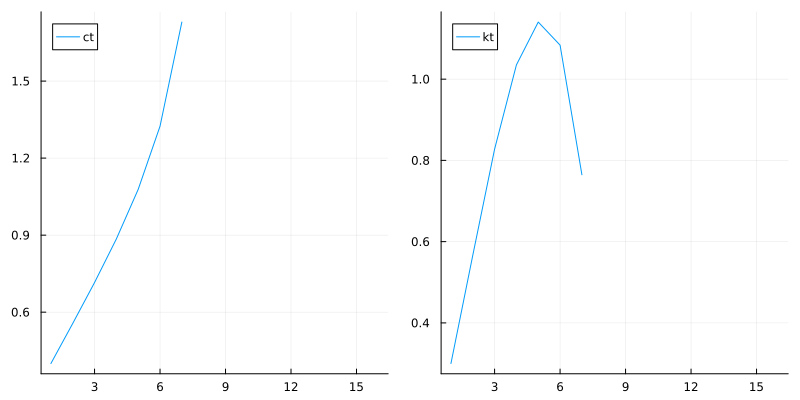

In [5]:
ck = p_gen( β=0.95, δ=0.02, α=0.33,N=15)
#shooting(ck, c0, k0)
ct,kt=shooting(ck, 0.4, 0.3);
pk=plot(kt, label="kt")
pc=plot(ct, label="ct")
pg_shooting=plot(pc,pk,size=(800, 400))

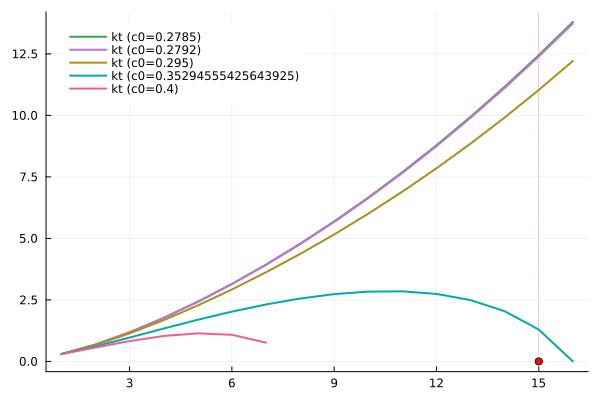

In [6]:
N = ck.N

c0_vec = [0.2785 0.2792 0.295 0.35294555425643925 0.4]
k0 = 0.3
c0 = 0.3
ct,kt = shooting(ck, c0, k0)
#plot(kt)
# Loop over each value of c0 in c0_vec
p = plot()
scatter!([N], [0], markercolor=:red,  label="")
vline!([N], linestyle=:dot, linewidth=0.5,  label="")
for c0 in c0_vec
    ct, kt = shooting(ck, c0, k0)
    plot!(p, kt, label="kt (c0=$c0)", linewidth=2, foreground_color_legend = nothing )
end
display(p)

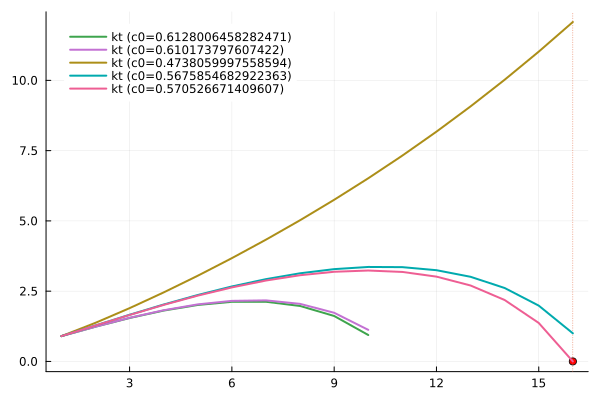

In [7]:
c0_vec = [ 0.6128006458282471 , 00.610173797607422 , 0.4738059997558594 , 0.5675854682922363, 0.570526671409607]
k0 = 0.9
#ct,kt = shooting(ck, c0, k0)
#plot(kt)
# Loop over each value of c0 in c0_vec
p = plot()
scatter!([N+1], [0], markercolor=:red,  label="")
vline!([N+1], linestyle=:dot, linewidth=0.5,  label="")
for c0 in c0_vec
    ct, kt = shooting(ck, c0, k0)
    plot!(p, kt, label="kt (c0=$c0)", linewidth=2, foreground_color_legend = nothing )
end
display(p)

# 3. Consumption-Saving model

The consumption-saving model, which is initially quite simple, allows for the analysis of complex macroeconomic problems such as changes in fiscal policy, pension systems, migration processes, demographic changes, among others. Some applications:

•⁠  ⁠[Sustaining Fiscal Policy through Immigration](https://www.journals.uchicago.edu/doi/10.1086/262120) (Storesletten, 2000). 
•⁠  ⁠[Quantifying the Effects of the Demographic Transition in Developing Economies](https://web.archive.org/web/20060908113117id_/http://homepages.nyu.edu/~sk910/research/DemogSouth.pdf) (Attanasio, Kita & Violante, 2006). 
•⁠  ⁠[Global demographic trends and social security reform](https://www.sciencedirect.com/science/article/pii/S0304393206002431) (Attanasio, Kitao & Violante, 2006)
•⁠  ⁠[Taxing Capital? Not a Bad Idea After All!](https://www.aeaweb.org/articles?id=10.1257/aer.99.1.25) (Conesa, Kitao & Krueger, 2009). 

In this section of the course, we are going to solve the basic $T$ periods model using different techniques: 
•⁠  ⁠Unconstraint minimization
•⁠  ⁠Constraint minimization
•⁠  ⁠Euler equation system 
•⁠  ⁠Shooting 
•⁠  ⁠Value Funtion Iteration

Then, you are going to test which is better.  Later, we will code tax and pension applications. 


In the consumption-saving model, there is a representative agent who lives for $T$ periods. The agent must choose the optimal consumption $\{c_t\}_{t=0}^T $. The preferences are represented by utility $u(c_t)$ where: 

$$U(\{c_t\})=\sum{t=0}^{T}\beta^t u(c_t)$$


The stationary discounting factor $0<\beta<1$. The utility function $u(c)$ satisfies the following properties: 

1.⁠ ⁠$u(c)$ is strictly increasing
2.⁠ ⁠$u(c)$ is strictly concave
3.⁠ ⁠$\lim_{c\rightarrow 0} u^{'}(c)=\infty$

The initial amount of assets is given by $a_0$ and the terminal condition $a_{T+1}\ge 0$. The net interest rate earned on savings is $r_t$. The budget constraint is

$$c_t = y_t + (1+r_t)a_t - a_{t+1}$$

The dynamic optimization problem of the agent can be written as 

$$ \max_{\{c_t, a_{t+1}\}{t=0}^{T} } \sum{t=0}^T \beta^t u(c_t) $$
$$\text{s.t.}  $$
$$a_0 = \overline{a} $$
$$c_t = y_t + (1+r_t)a_t - a_{t+1}   $$
$$c_t \ge 0  $$
$$a_{t+1} \ge \underline{a}  $$
$$a_{T+1} = 0   $$

First Orden conditions:

FOC wrt $c_t$
\
FOC wrt $a_{t+1}$
\
Assuming a lagrange multiplier, $\lambda_t$
\
with utility function:
$$u(c)=\frac{c^{1-\sigma}}{1-\sigma}$$

1.⁠ ⁠FOC wrt $c_t$:
$$u^{'}(c_t)=\lambda_t$$

2.⁠ ⁠FOC wrt $a_{t+1}$:
$$\beta \lambda_{t+1} =\lambda_t$$

Using the functional form of utility, we can re-write the FOCs as:
\

1.⁠ ⁠FOC wrt $c_t$:
$$(c_t)^{-\sigma}=\lambda_t$$

2.⁠ ⁠FOC wrt $a_{t+1}$:
$$c_{t+1}=c_{t}\left(\beta(1+r)\right)^{1/\sigma} (1)$$ 
3.⁠ ⁠Budget constraint (F.O.C wrt $\lambda_t$)
$$a_{t+1} = y_t + (1+r_t)a_t -c_t (2) $$

In [8]:
# Initial guess
parametros_iniciales = @with_kw (σ=2,
β=0.95,
rt=0.001,
yt=1,
a0=15,
c0=60,
aT=0,
N=15,
);

In [9]:
ck=parametros_iniciales()

(σ = 2, β = 0.95, rt = 0.001, yt = 1, a0 = 15, c0 = 60, aT = 0, N = 15)

In [10]:
function shooting_c(ck, c0, a0)
    (;σ,β,yt,rt,N,aT) = ck

    a1t   = NaN*ones(N+1)
    ct   = NaN*ones(N+1)
    #kt   = Vector{Union{Missing, Float64}}(missing, N+1)
    #ct   = Vector{Union{Missing, Float64}}(missing, N+1)
    a1t[1] = a0
    ct[1] = c0

    for t = 1:N
        #println(t," ct : ",ct[t],"  kt : ",kt[t])
        y_deprec = yt+ (1+rt)*a1t[t]
        if ct[t]>=y_deprec
            #println("initial consumption is not feasible")
            break
        end
        #println(t," ct : ",ct[t],"  yt_dep : ",y_deprec,"  kt : ",kt[t])
        ct[t+1] = ct[t]*(β*(1+rt))^(1/σ) #equation (1)
        a1t[t+1] = yt + (1+rt)*a1t[t] - ct[t] #equation (2)
    end
    ct,a1t
end

shooting_c (generic function with 1 method)

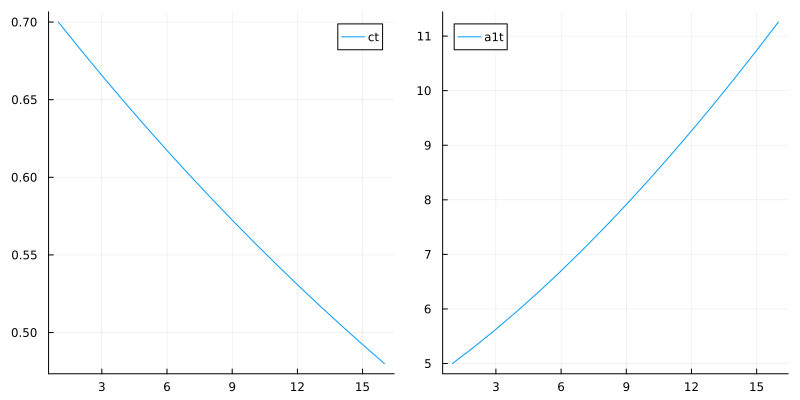

In [11]:
#ck = p_gen( β=0.95, δ=0.02, α=0.33,N=15)
#shooting(ck, c0, k0)
ct,a1t=shooting_c(ck, 0.7, 5);
pa1t=plot(a1t, label="a1t")
p_c=plot(ct, label="ct")
pg_shooting_c=plot(p_c,pa1t,size=(800, 400))

In [12]:
function bisection_c(ck, c0, a0; tol=1e-4, max_iter=500, a1_ter=0, verbose=true)
    (;β,σ,yt,rt) = ck

    # initial boundaries for guess c0
    c0_upper = yt
    c0_lower = 0
    c0_vec1 = []

    i = 0
    while true
        #println(i," ",c0," ", k0)
        ct, a1t = shooting_c(ck, c0, a0)
        error = a1t[end] - a1_ter
        #println(error)
        # check if the terminal condition is satisfied
        if abs(error) < tol
            if verbose
                println("Converged successfully on iteration ", i+1)
            end
            return ct, a1t, c0_vec1
        end

        i += 1
        if i == max_iter
            if verbose
                println("Convergence failed.")
            end
            return ct, a1t
        end

        # if iteration continues, updates boundaries and guess of c0
        #print("before if",ismissing(error) )
        if error > 0 
            c0_lower = c0
        else
            c0_upper = c0
        end

        c0 = (c0_lower + c0_upper) / 2
        #c0_vec[i] = c0
        append!(c0_vec1, c0)
        #println(c0)
        #return c0_vec1
    end
end

bisection_c (generic function with 1 method)

Converged successfully on iteration 21


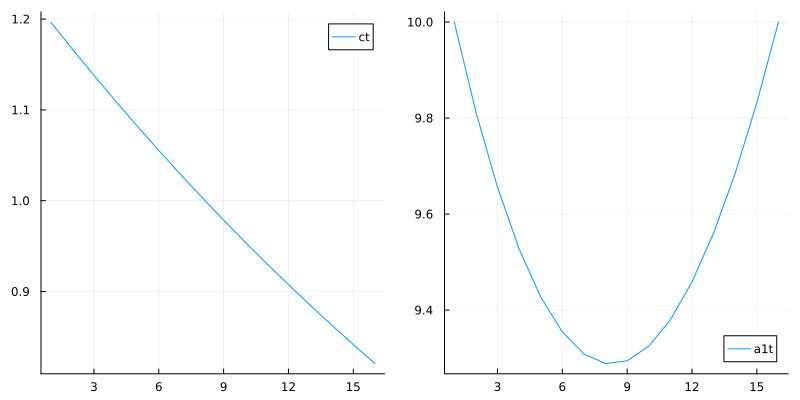

In [13]:
ct,a1t=bisection_c(ck, 10, 10,a1_ter=10);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

Converged successfully on iteration 21


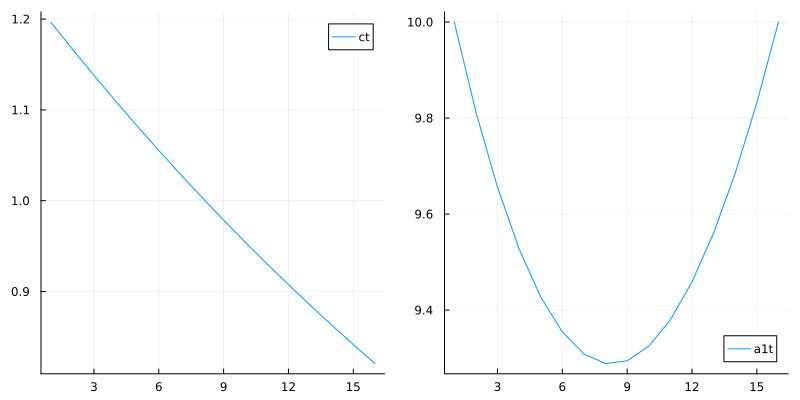

In [14]:
ct,a1t=bisection_c(ck, 10, 10,a1_ter=10);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

## 4. Escenario Clase 26 de Junio

Converged successfully on iteration 26


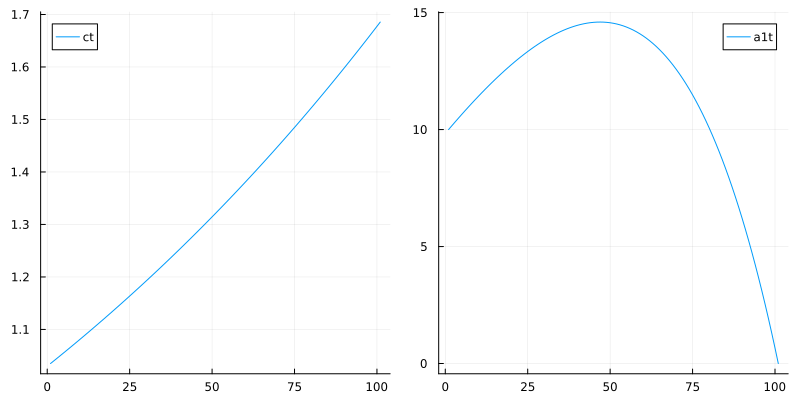

In [15]:
ck = parametros_iniciales(rt=0.02,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=0);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

# Tarea 

1. Encuentre la tasa de interés que hace que el consumo sea plano (horizontal).
2. Recree 1) moviendo el ahorro final con los valores (10,1).
3. Genere un bisection que permita que el ahorro sea negativo (deuda). Y ver que sucede con esta calibración.
3.1.  Generar un nivel inicial de riqueza de modo que no ahorre. ( Hint: Baje la riqueza inicial).

# Pauta 

1. Encuentre la tasa de interés que hace que el consumo sea plano (horizontal).
2. Recree 1) moviendo el ahorro final con los valores (10,1).
3. Genere un bisection que permita que el ahorro sea negativo (deuda). Y ver que sucede con esta calibración. \
3.1.  Generar un nivel inicial de riqueza de modo que no ahorre. ( Hint: Baje la riqueza inicial).

1. Encuentre la tasa de interés que hace que el consumo sea plano (horizontal).
We know from the FOC that:
$$c_{t+1}=c_{t}\left(\beta(1+r)\right)^{1/\sigma} (1)$$ 
there is an interest rate, $r$, that makes $c_{t+1}=c_{t}$, given $\beta$. We can find the rate analytically, or trying different values pf $r$. Below, we try some values of $r$, below $r=2\%$



## What about r=0.01?


Converged successfully on iteration 25


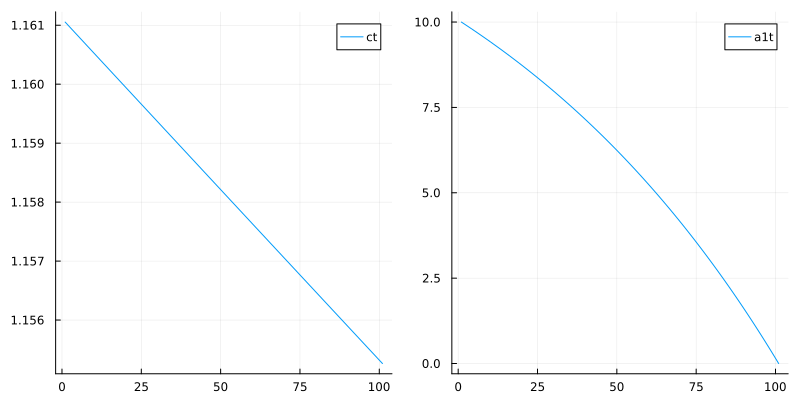

In [16]:
r_try=0.01
ck = parametros_iniciales(rt=r_try,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=0);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))


## What about r=0.015?

Converged successfully on iteration 26


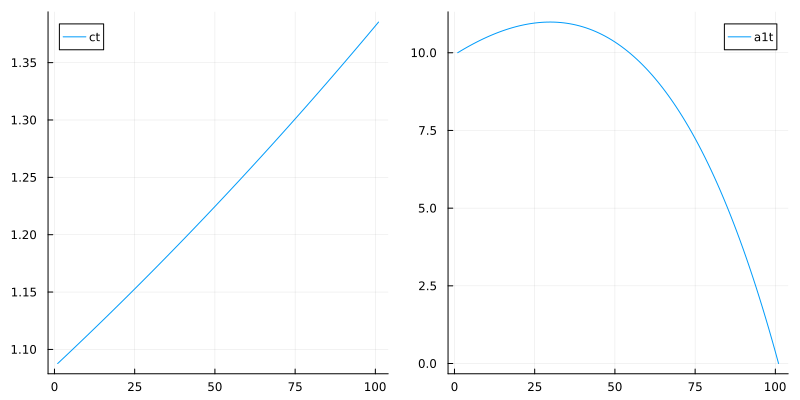

In [17]:
r_try=0.015
ck = parametros_iniciales(rt=r_try,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=0);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

## What about r=0.0101?

In [18]:
(1/ck.β)-1

0.010101010101010166

Converged successfully on iteration 25


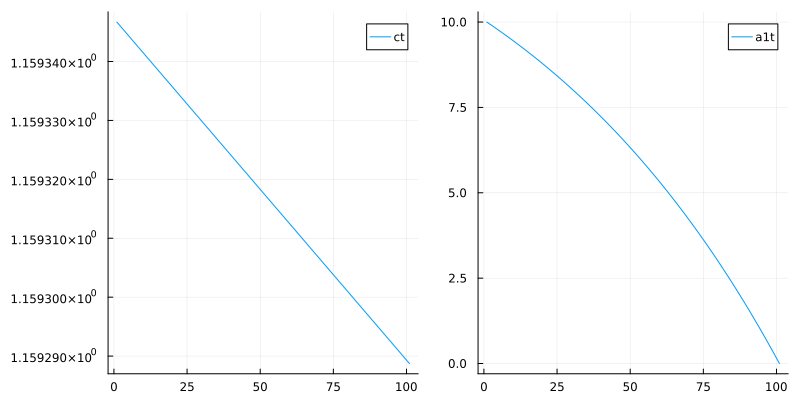

In [19]:
r_try=0.0101
ck = parametros_iniciales(rt=r_try,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=0);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

## A rate r=0.0101 seems to work well.......it is more evident if we plot consumption (ct) and assets (a1)

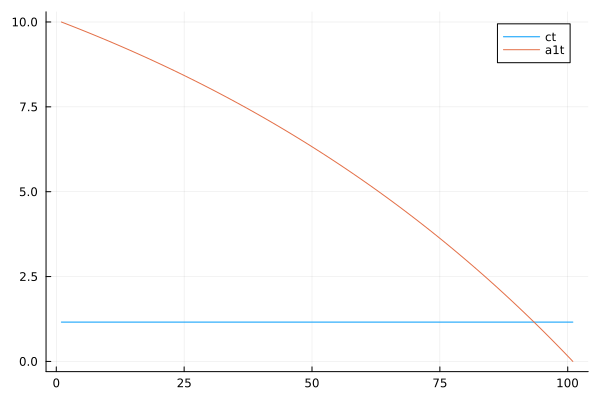

In [20]:
plot(ct,label="ct")
plot!(a1t, label="a1t")

## 2. Recree (1) moviendo el ahorro final con los valores (10,1).
### Need to change a1_ter=10 and a1_ter=1 from the initial value a1_ter=0

#### 2.1 a1_ter=10 


Converged successfully on iteration 25


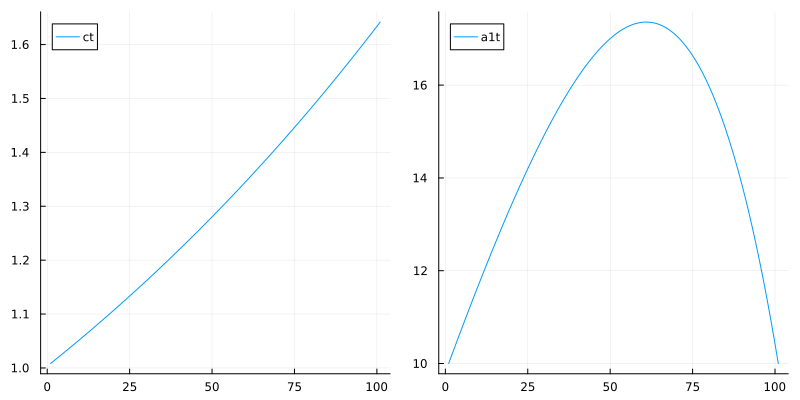

In [21]:
ck = parametros_iniciales(rt=0.02,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=10);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

### Reduce r=0.0101 to test what is happening

Converged successfully on iteration 24


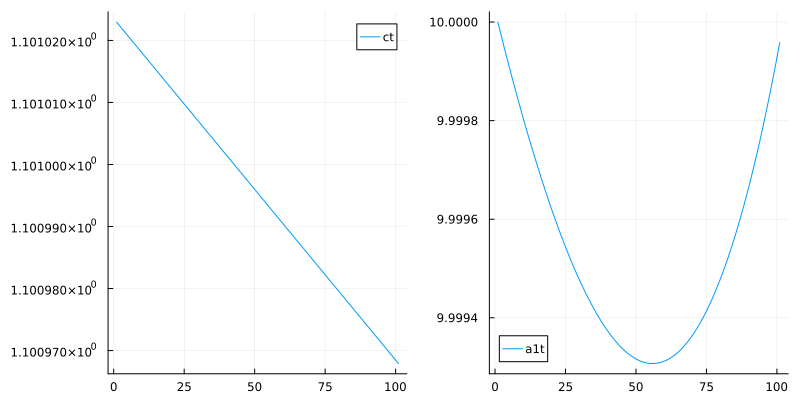

In [22]:
ck = parametros_iniciales(rt=0.0101,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=10);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

## Eureka!!! r=0.0101 works well!!

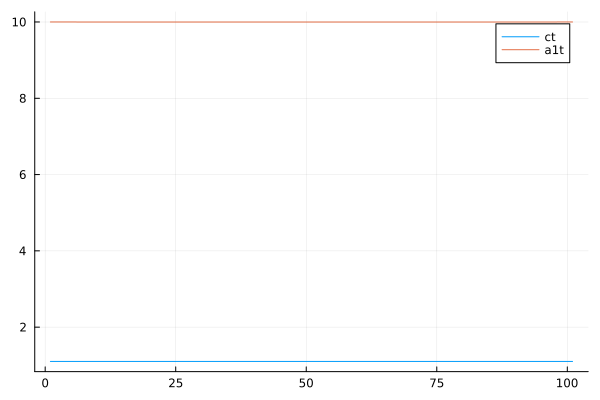

In [23]:
plot(ct,label="ct")
plot!(a1t, label="a1t")

#### 2.1 a1_ter=1

Converged successfully on iteration 20


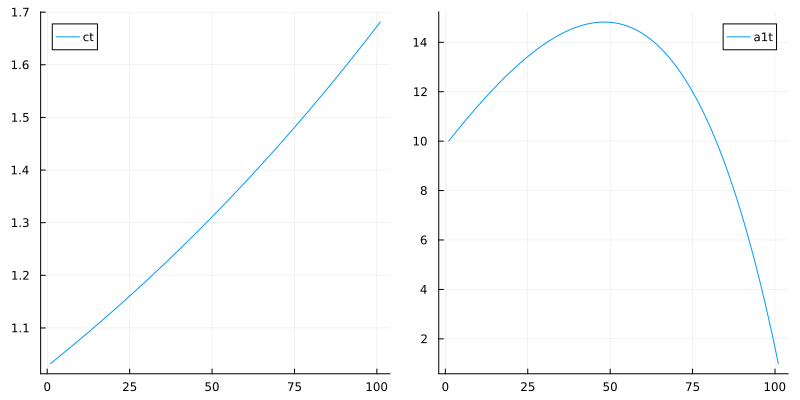

In [24]:
ck = parametros_iniciales(rt=0.02,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=1);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

### Reduce r=0.0101 to test what is happening

Converged successfully on iteration 23


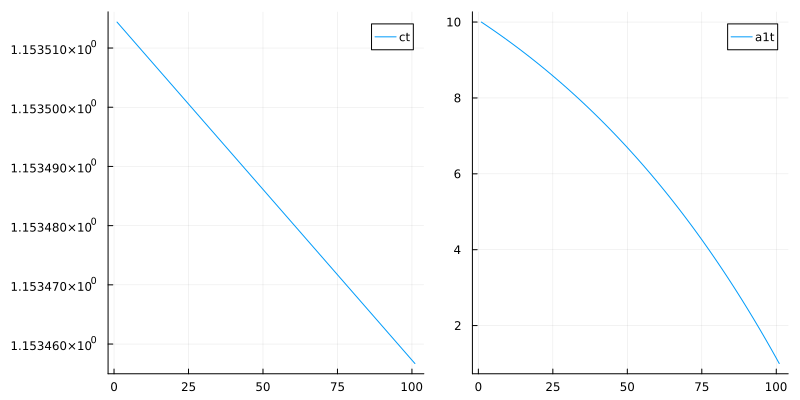

In [25]:
ck = parametros_iniciales(rt=0.0101,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=1);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

## Eureka!!! r=0.0101 works well!! (Again)

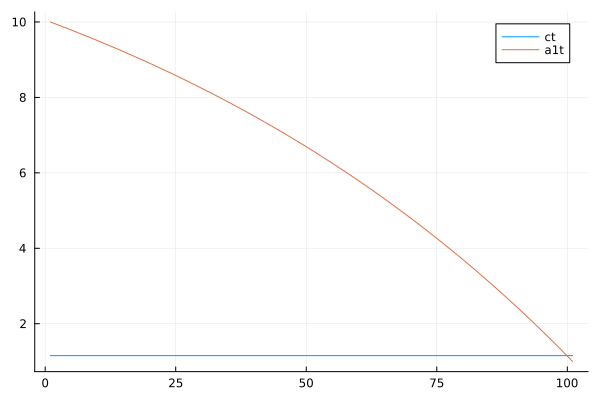

In [26]:
plot(ct,label="ct")
plot!(a1t, label="a1t")

## Why r=0.0101 works well all the time?. 
The reason is that the Euler equation relating consumption in $t$ and $t+1$ does not depend on the innitial stock of wealth: $$c_{t+1}=c_{t}\left(\beta(1+r)\right)^{1/\sigma} (1)$$ 



## 3. Genere un bisection que permita que el ahorro sea negativo (deuda). Y ver que sucede con esta calibración.

Well, we need to re-define function to allow for negative assests. Need to change the shooting function and incorporate this into the bisection function.

To keep track of changes: change the name of the modified functions

### New Shooting Function
Notice that these lines in the original function, shooting_c(ck, c0, a0):

************************************************************
  for t = 1:N
        #println(t," ct : ",ct[t],"  kt : ",kt[t])
        y_deprec = yt+ (1+rt)*a1t[t]
        if ct[t]>=y_deprec
            #println("initial consumption is not feasible")
            break
        end
************************************************************

prevent consumption above income, if ct[t]>=y_deprec, then break. This is equivalent to impose positive assets. To see this, recall that the budget constraint can be expressed as:

$$a_{t+1} = y_t + (1+r_t)a_t - c_t$$
If we impose if $c_t> y_t + (1+r_t)a_t$, then break, we exclude negative values of $a_{t+1}$. 

Hence to allow negative values of $a_t$ we remove this restriction. Below, the modified code

In [27]:
function shooting_c_a(ck, c0, a0)
    (;σ,β,yt,rt,N,aT) = ck

    a1t   = NaN*ones(N+1)
    ct   = NaN*ones(N+1)
    #kt   = Vector{Union{Missing, Float64}}(missing, N+1)
    #ct   = Vector{Union{Missing, Float64}}(missing, N+1)
    a1t[1] = a0
    ct[1] = c0

    for t = 1:N
        #println(t," ct : ",ct[t],"  kt : ",kt[t])
       # y_deprec = yt+ (1+rt)*a1t[t] #comment this for allow negative values of a_t
       # if ct[t]>=y_deprec           #comment this for allow negative values of a_t
            #println("initial consumption is not feasible")
        #    break                    #comment this for allow negative values of a_t
        # end                         #comment this for allow negative values of a_t 
        #println(t," ct : ",ct[t],"  yt_dep : ",y_deprec,"  kt : ",kt[t])
        ct[t+1] = ct[t]*(β*(1+rt))^(1/σ) #equation (1)
        a1t[t+1] = yt + (1+rt)*a1t[t] - ct[t] #equation (2)
    end
    ct,a1t
end

shooting_c_a (generic function with 1 method)

we plug the previous shooting code into a new bisection code

In [28]:
function bisection_c_a(ck, c0, a0; tol=1e-4, max_iter=500, a1_ter=0, verbose=true)
    (;β,σ,yt,rt) = ck

    # initial boundaries for guess c0
    c0_upper = yt
    c0_lower = 0
    c0_vec1 = []

    i = 0
    while true
        #println(i," ",c0," ", k0)
        ct, a1t = shooting_c_a(ck, c0, a0) # Need to introduce the new shooting
        error = a1t[end] - a1_ter
        #println(error)
        # check if the terminal condition is satisfied
        if abs(error) < tol
            if verbose
                println("Converged successfully on iteration ", i+1)
            end
            return ct, a1t, c0_vec1
        end

        i += 1
        if i == max_iter
            if verbose
                println("Convergence failed.")
            end
            return ct, a1t
        end

        # if iteration continues, updates boundaries and guess of c0
        #print("before if",ismissing(error) )
        if error > 0 
            c0_lower = c0
        else
            c0_upper = c0
        end

        c0 = (c0_lower + c0_upper) / 2
        #c0_vec[i] = c0
        append!(c0_vec1, c0)
        #println(c0)
        #return c0_vec1
    end
end

bisection_c_a (generic function with 1 method)

## Testing our new function

### First: the original function with intial capital=0

Converged successfully on iteration 20

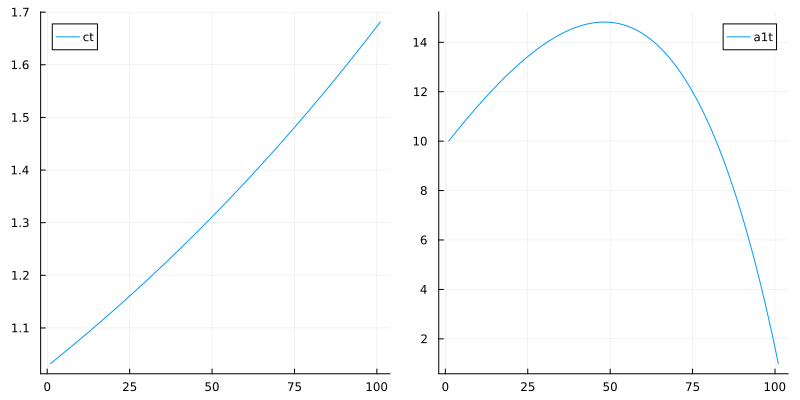

In [29]:
#bisection(ck, c0, k0; tol=1e-4, max_iter=500, k_ter=0, verbose=true)
ck = parametros_iniciales(rt=0.02,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c(ck, 10, 10,a1_ter=1);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

### Second: our new function with low initial capital

Converged successfully on iteration 20


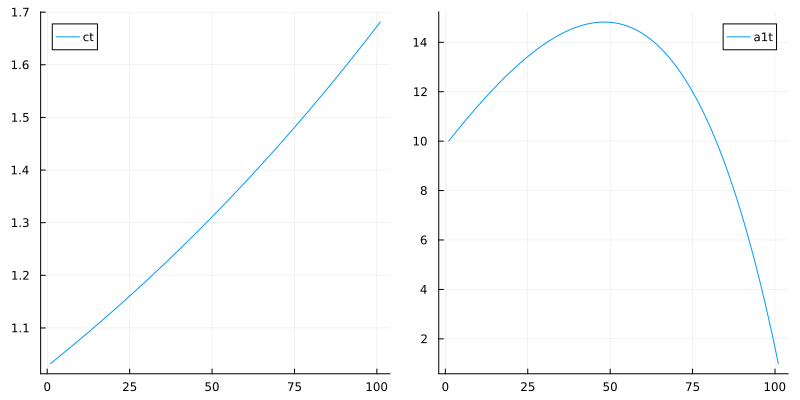

In [30]:
#bisection(ck, c0, k0; tol=1e-4, max_iter=500, k_ter=0, verbose=true)
ck = parametros_iniciales(rt=0.02,N=100,β=0.99) # Forma de cambiar parametros
ct,a1t=bisection_c_a(ck, 10, 10,a1_ter=1);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

### Both functions are almost identincals!!! What next???
Answer: need to induce houselholds to value more current consumption. Or in other words, to value "less" future consumption
How we do it???
Answer: Reduce the "value" of future consumption. This is the same as a reduction in β. We reduce this valu from β=0.99 to  β=0.97

Converged successfully on iteration 25


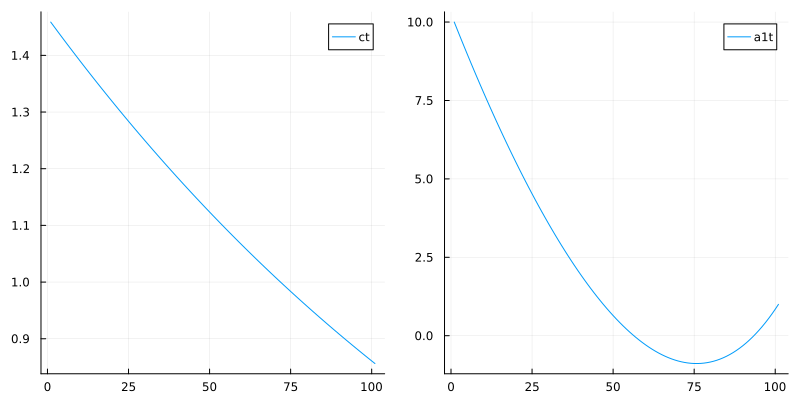

In [31]:
#bisection(ck, c0, k0; tol=1e-4, max_iter=500, k_ter=0, verbose=true)
ck = parametros_iniciales(rt=0.02,N=100,β=0.97) # Forma de cambiar parametros
ct,a1t=bisection_c_a(ck, 10, 10,a1_ter=1);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))

## Eureka: we could generate debt. It has to be paid, to end with a final wealth level of 10!!
Households: at the begining deacumulate capital, then have debt and then, save



### 3.1.  Generar un nivel inicial de riqueza de modo que no ahorre. ( Hint: Baje la riqueza inicial).
Answer: we reduce the initial wealth to cero and terminal assets to zero

Converged successfully on iteration 23


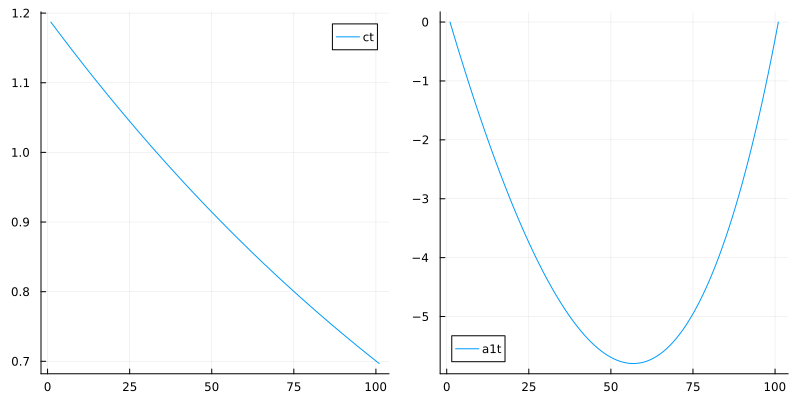

In [32]:
#bisection(ck, c0, k0; tol=1e-4, max_iter=500, k_ter=0, verbose=true)
ck = parametros_iniciales(rt=0.02,N=100,β=0.97) # Forma de cambiar parametros
ct,a1t=bisection_c_a(ck, 10, 0,a1_ter=0);
pa=plot(a1t, label="a1t")
pc=plot(ct, label="ct")
pg_shooting_c=plot(pc,pa,size=(800, 400))